## Picking 3rd fold: Model

In [1]:
import torch
import torch.utils.data as data_utils
import h5py
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold

from models import cnn_rnn
from utils import test_seq, normalize_mel_sp_slides

import torch
from models import cnn_rnn
import numpy as np


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

dataDir = './data'
tempDir = 'temp'

fname = 'birds_xeno_spectr_slide_105_species_sr_32000_len_7_sec_500_250_New.h5'
fileLoc = f"{dataDir}/{fname}"

# Load mel spectrograms
hf = h5py.File(fileLoc, 'r')
mel_sp = hf.get('mel_spectr')[()]
metadata_total = pd.read_hdf(fileLoc, 'info')
hf.close()

# Encode labels
original_label = list(metadata_total['species'])
lb_bin = LabelBinarizer()
lb_enc = LabelEncoder()
labels_one_hot = lb_bin.fit_transform(original_label)
labels_multi_lbl = lb_enc.fit_transform(original_label)

number_of_classes = len(lb_enc.classes_)
print("Number of species:", number_of_classes)

# Normalize mel spectrograms
mel_sp_normalized = []
for i in range(len(mel_sp)):
    xx_ = normalize_mel_sp_slides(mel_sp[i]).astype('float32')
    mel_sp_normalized.append(np.expand_dims(xx_, axis=-3))
mel_sp_normalized = np.array(mel_sp_normalized)


Number of species: 105


### Data Splitting and picking 3rd fold as it recorded best model

In [3]:
batch_size = 32
hidden_size = 256
cfg_cnn3 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
n_units = 512*2

# Select the RNN config you trained (match with your exp_no / exp_ind)
rnnConfig = {'LSTM_0': {'input_size': n_units, 'h_states_ctr': 2},
             'LSTM_1': {'input_size': hidden_size, 'h_states_ctr': 2}}

skf = StratifiedKFold(n_splits=5, random_state=42)
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(mel_sp_normalized, labels_multi_lbl)):
    if fold_idx == 2:  # pick the third fold
        X_train, X_test_valid = mel_sp_normalized[train_idx], mel_sp_normalized[test_idx]
        y_train, y_test_valid = labels_one_hot[train_idx], labels_one_hot[test_idx]
        y_train_mlbl, y_test_valid_mlbl = labels_multi_lbl[train_idx], labels_multi_lbl[test_idx]
        break

# Split X_test_valid into validation and test (same as training)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test_valid, y_test_valid, test_size=0.5,
    stratify=y_test_valid_mlbl, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

# Convert to PyTorch tensors
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float()

# Train DataLoader
train_dataset = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Test DataLoader
test_dataset = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Valid DataLoader
valid_dataset = data_utils.TensorDataset(X_valid, y_valid)
valid_loader = data_utils.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


### Reloading Model

In [4]:
hidden_size = 256
cfg_cnn3 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'] # CNN3
cfg = {'LSTM_0':{'input_size':1024, 'h_states_ctr':2},
    'LSTM_1':{'input_size':hidden_size, 'h_states_ctr':2}  # 2 layers of LSTM cell
    }
#Recreating Model Architecture
model = cnn_rnn(cnnConfig = cfg_cnn3, 
                        rnnConfig = cfg, 
                        hidden_size=hidden_size, 
                        # order=order,
                        # theta=theta,
                        num_classes=105)


#Filling weights
state_dict = torch.load("./model_256_hidden_size/currentModel_cnn_rnn_1_2.pt", map_location="cuda:1")
model.load_state_dict(state_dict)
model = model.to("cuda:1")
model.eval()

cnn_rnn(
  (cnn): cnn(
    (convBlock): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

### Extracting embedding for test samples

In [5]:
all_embeddings = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to("cuda:1")
        hidden = model.init_hidden(X.size(0))
        hidden = tuple(h.to("cuda:1") for h in hidden)

        emb = model.extract_features(X, hidden)  # (batch, 512)

        all_embeddings.append(emb.cpu().numpy())
        all_labels.append(y.numpy())

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(all_embeddings.shape)   # (N_samples, 512)

(5250, 512)


### Perform PCA → t-SNE

In [6]:
from sklearn.decomposition import PCA

# Speed up t-SNE using PCA
pca = PCA(n_components=60)
pca_feat = pca.fit_transform(all_embeddings)

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=110, learning_rate=500, n_iter=3500,init='pca')
tsne_2d = tsne.fit_transform(pca_feat)

In [8]:
tsne_2d

array([[  9.084917  ,  19.83936   ],
       [ 14.885551  , -21.415785  ],
       [ -9.141939  , -28.227034  ],
       ...,
       [ -3.4492483 , -36.442646  ],
       [ -0.34736773, -13.933541  ],
       [-29.522076  ,  37.96711   ]], dtype=float32)

### Visualization of test set in 2D

In [9]:
all_labels.shape

(5250, 105)

In [10]:
labels_1d = np.argmax(all_labels, axis=1)
labels_1d.shape

(5250,)

In [11]:
labels_1d

array([  7, 104,  89, ...,  80,  79,  86])

In [12]:
tsne_2d.shape

(5250, 2)

In [20]:
lb_enc.inverse_transform([1])[0]

'Acrocephalusdumetorum'

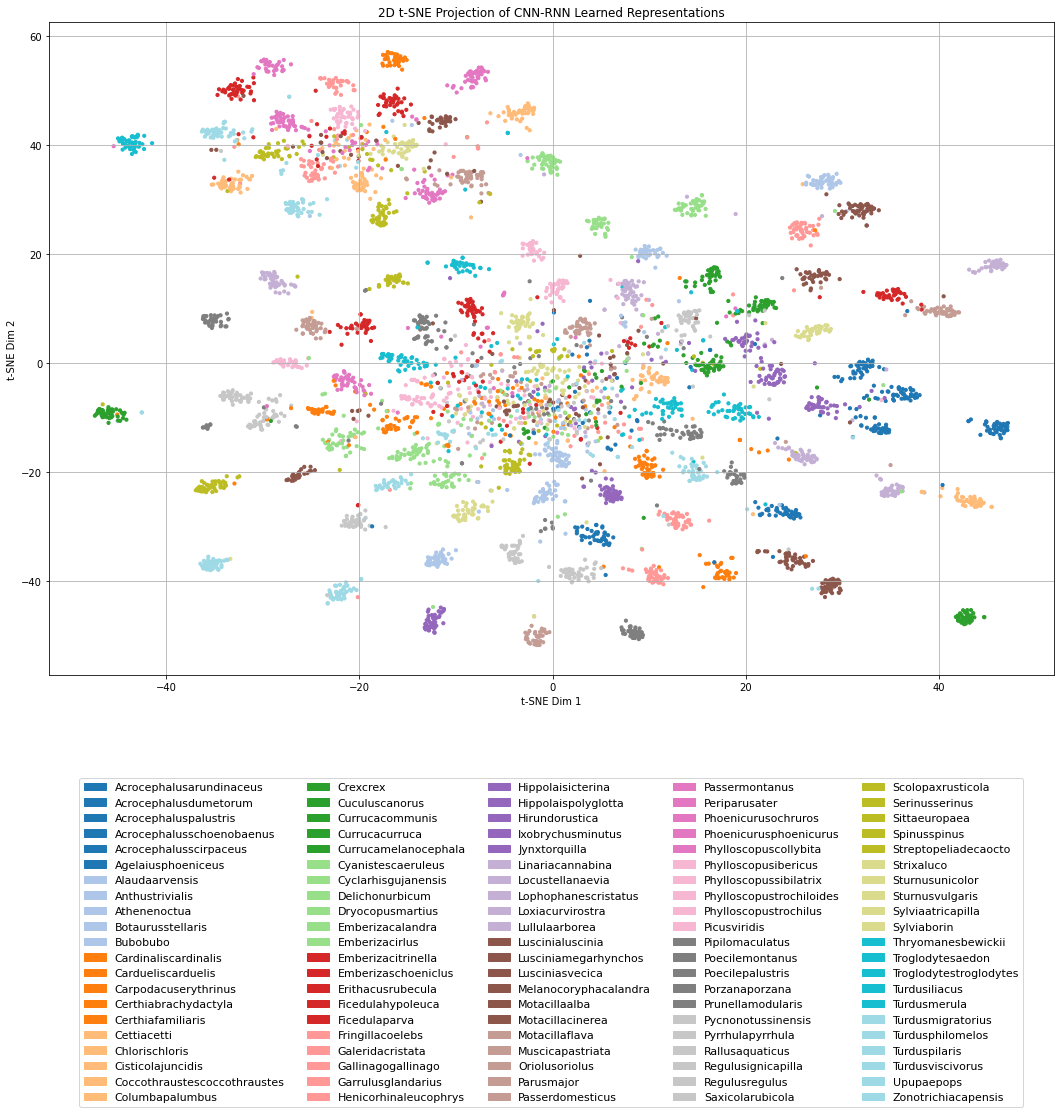

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(18, 12))
scatter = plt.scatter(tsne_2d[:,0], tsne_2d[:,1], 
                      c=labels_1d, cmap="tab20", s=10)

plt.title("2D t-SNE Projection of CNN-RNN Learned Representations")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
# plt.colorbar(scatter)
plt.grid(True)


# Unique class labels
unique_classes = np.unique(labels_1d)

# Create legend patches for each class
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(cls)), label=f"{lb_enc.inverse_transform([cls])[0]}") 
           for cls in unique_classes]

# Plot the legend below the chart
plt.legend(handles=handles,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.15),  # move further down
           ncol=5,                       # change based on number of classes
           fontsize=11)




plt.show()


### Visualization of chunks having 35 classes

In [36]:
## Step-1 Get unique chunks
import numpy as np

unique_classes = np.unique(labels_1d)
num_classes = len(unique_classes)

print("Total classes:", num_classes)


Total classes: 105


In [37]:
#Step 2 — Split classes into chunks of 35
chunk_size = 21
class_chunks = [unique_classes[i:i + chunk_size] 
                for i in range(0, num_classes, chunk_size)]


In [38]:
class_chunks

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41]),
 array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 60, 61, 62]),
 array([63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
        80, 81, 82, 83]),
 array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104])]

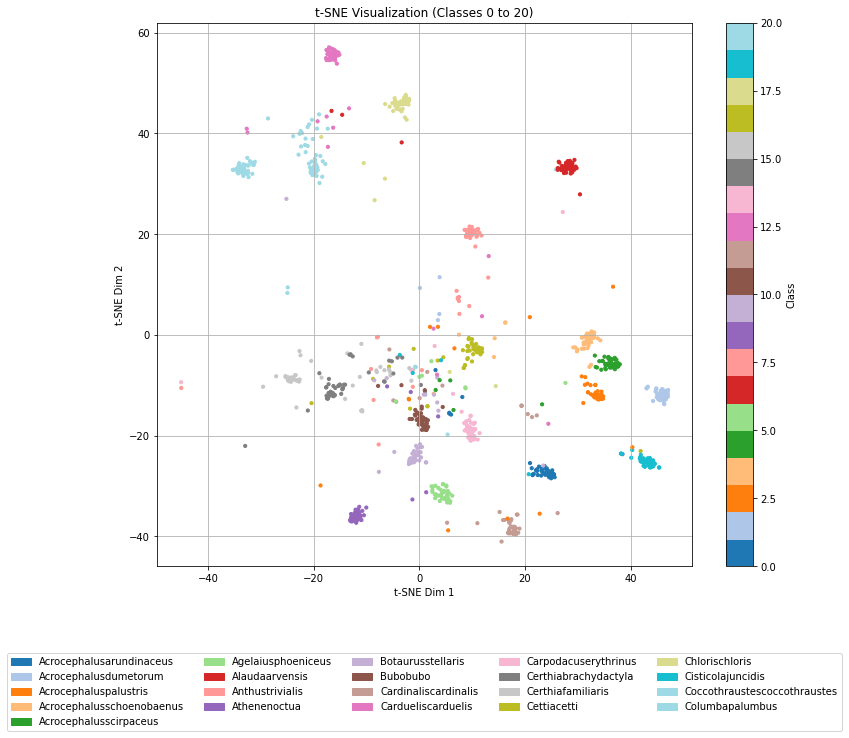

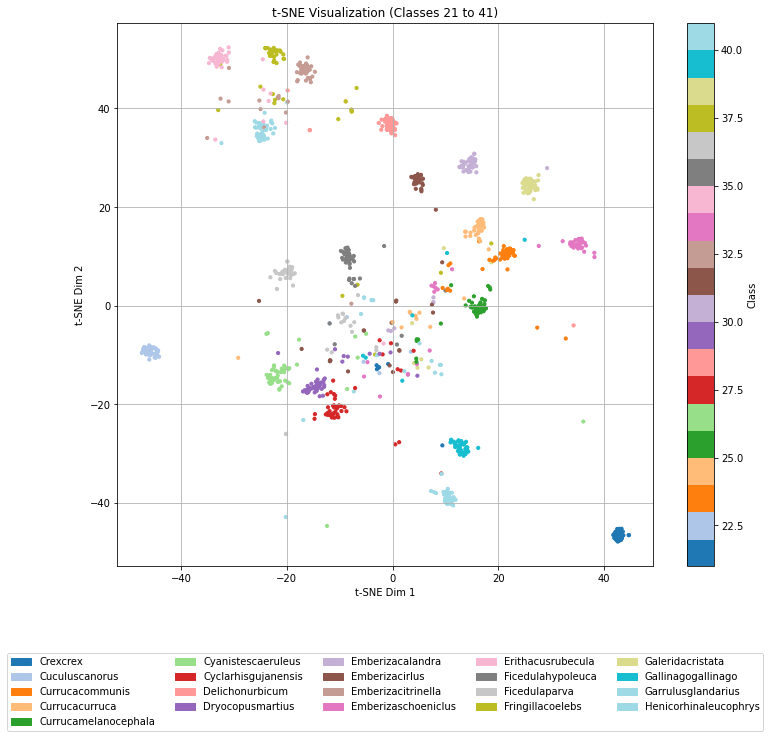

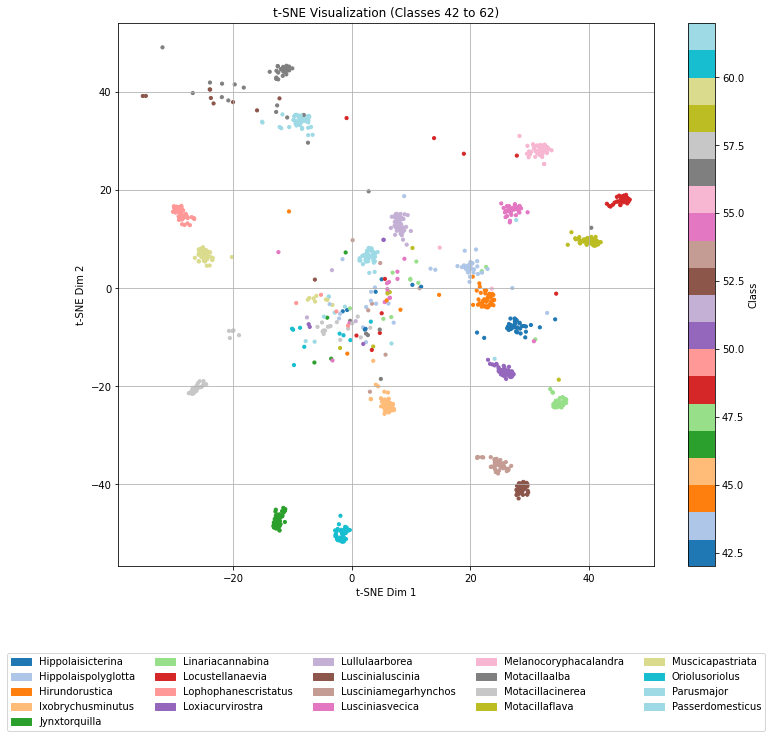

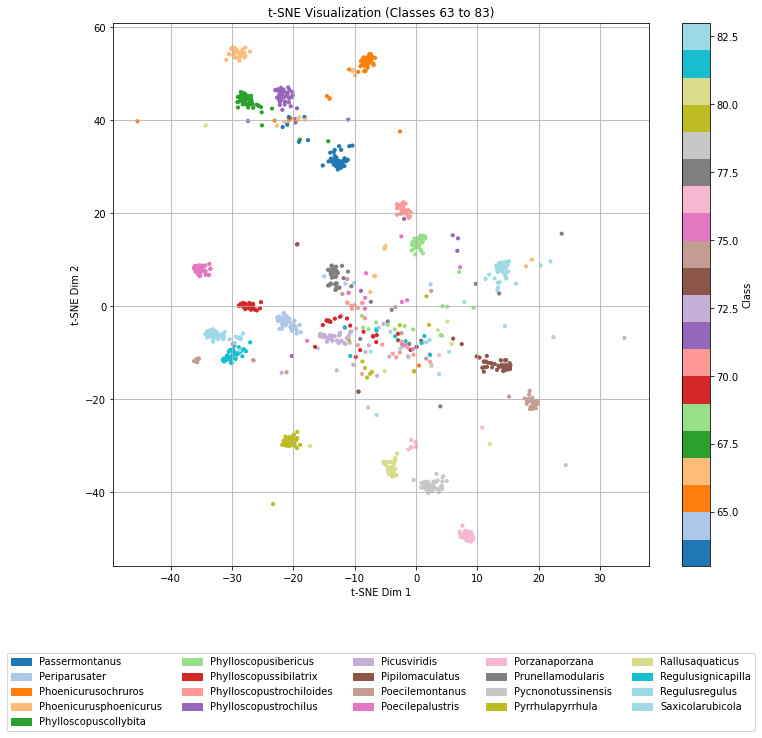

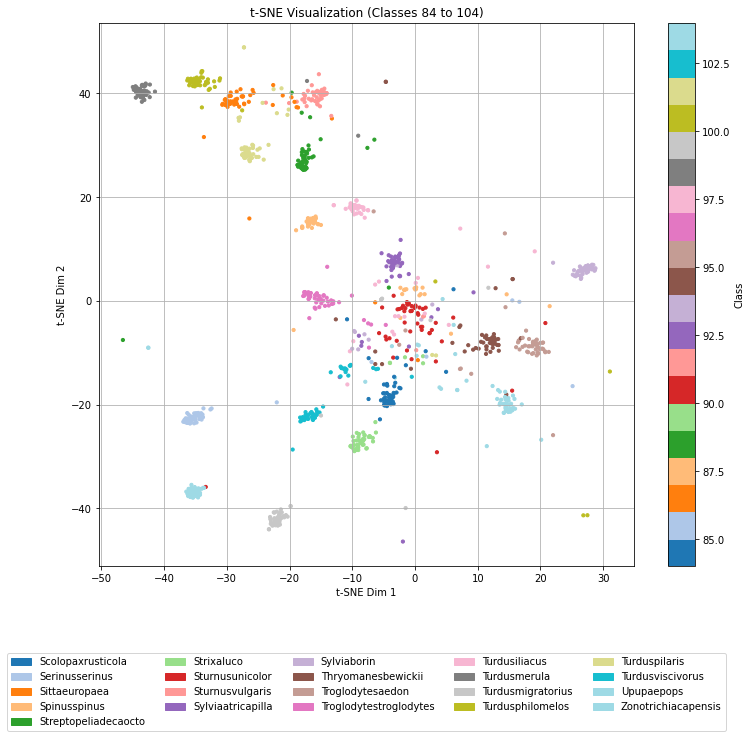

In [42]:
#Step 3 — Visualize each chunk separately
import matplotlib.pyplot as plt

for idx, cls_group in enumerate(class_chunks):

    # mask for data points belonging to this class group
    mask = np.isin(labels_1d, cls_group)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        tsne_2d[mask, 0],
        tsne_2d[mask, 1],
        c=labels_1d[mask],
        cmap="tab20",
        s=10
    )

    plt.title(f"t-SNE Visualization (Classes {cls_group[0]} to {cls_group[-1]})")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.colorbar(scatter, label="Class")
    plt.grid(True)



    # Create legend handles only for classes in this chunk
    handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(cls)), label=f"{lb_enc.inverse_transform([cls])[0]}") 
               for cls in cls_group]

    # Bottom legend outside plot
    plt.legend(handles=handles,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.15),
               ncol=5,                # adjust based on chunk size
               fontsize=10)


    plt.show()